In [2]:
import re, os, glob
import json
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.table import Table, Column
import FoFCatalogMatching
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from detectron2.structures import BoxMode

/home/yse2/.conda/envs/deepdisc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# combined = None
# with open('roman_data/annotations-combined/test_roman.json', 'r') as f:
#     combined = True
#     data = json.load(f)
# lsst
with open('lsst_data/annotationsc-ups/test.json', 'r') as f:
    data = json.load(f)

In [4]:
# run_dir = 'roman_runs/run20-combined-swin'
run_dir = '/home/shared/hsc/roman_lsst/lsst_runs/run4_ups_roman'
with open(f'{run_dir}/all_matched_gts.pkl', 'rb') as f:
    all_matched_gts = pickle.load(f)

In [5]:
all_matched_gts[0]

{0,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 31,
 32,
 33,
 34}

In [44]:
lsst_det = pd.read_json('lsst_det_cat.json')

In [13]:
lsst_det

,mag_z,mag_g,mag_r,good,extendedness,mag_y,mag_u,mag_i,dec,mag_i_cModel,mag_y_cModel,mag_g_cModel,objectId,ra,mag_u_cModel,mag_z_cModel,mag_r_cModel
0,25.560761,27.884573,27.109825,True,0.0,25.294219,28.637055,26.065308,-41.381389,25.985919,25.226684,27.780498,14320043735125727,51.405403,28.069800,25.386938,27.055265
1,26.038546,26.118646,26.231557,True,0.0,24.910521,26.343419,26.056877,-41.381347,25.462291,24.664625,25.577207,14320043735125733,51.378494,25.957312,25.224127,25.696985
2,25.741506,27.521972,27.184989,True,1.0,24.968896,26.452720,25.981594,-41.381554,25.999721,24.950606,27.549614,14320043735125736,51.366823,26.458188,25.753033,27.196259
3,24.766488,24.957658,24.882803,True,0.0,24.215553,25.061350,24.865878,-41.380936,24.684433,24.060238,24.739212,14320043735125741,51.418346,24.912435,24.544637,24.647460
4,25.814908,26.258970,25.487328,True,0.0,25.266101,26.918089,25.282063,-41.380892,25.011395,24.994890,26.000088,14320043735125755,51.395640,26.700084,25.529731,25.233211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66751,29.624132,27.281445,27.443989,True,0.0,25.996053,27.552627,30.317180,-40.865610,26.593282,25.247904,26.087479,14324725249520437,52.887330,26.084211,30.161806,26.206982
66752,25.573513,26.770085,27.386973,True,1.0,25.037064,27.352514,34.335265,-40.863959,NaN,25.196677,26.786871,14324725249520439,52.931635,27.321775,25.556598,27.417072
66753,26.094657,26.626956,27.025510,True,0.0,30.912198,26.550205,27.036444,-40.862638,26.836736,NaN,26.234877,14324725249520441,52.902561,26.040209,26.232695,26.845167
66754,31.067615,26.657518,26.938681,True,0.0,NaN,27.654602,34.334898,-40.863052,NaN,NaN,26.640209,14324725249520442,52.901798,27.556250,NaN,26.931299


In [5]:
# for lsst data
# lsst_truth_dc2 = pd.read_csv('/home/shared/hsc/DC2/raw_data/all_tracts_truth_cat.csv')
lsst_det_dc2 = pd.read_csv('/home/shared/hsc/DC2/raw_data/dr6/all_tracts_object_cat.csv')
# all_tracts_object_cat.csv

/tmp/ipykernel_4114603/777052699.py:3: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  lsst_det_dc2 = pd.read_csv('/home/shared/hsc/DC2/raw_data/dr6/all_tracts_object_cat.csv')


In [6]:
patches = ['1,1', '1,2', '1,3', '1,4', '1,5', '2,1', '2,2', '2,3', '2,4', '2,5']
lsst_det_dc2 = lsst_det_dc2[lsst_det_dc2['tract'] == 3828]
lsst_det_dc2 = lsst_det_dc2[lsst_det_dc2['patch'].isin(patches)]

In [7]:
lsst_det_dc2

,Unnamed: 0.1,Unnamed: 0,match_objectId,snr_g_cModel,magerr_i_cModel,magerr_z,objectId,magerr_y,magerr_g_cModel,mag_y_cModel,...,mag_g_cModel_dered,magerr_g_cModel_dered,mag_r_cModel_dered,magerr_r_cModel_dered,mag_i_cModel_dered,magerr_i_cModel_dered,mag_z_cModel_dered,magerr_z_cModel_dered,mag_y_cModel_dered,magerr_y_cModel_dered
153025,153025,153025,16835863778427143,36.138397,0.025687,0.056917,16835863778427143,0.080047,0.030044,23.042544,...,24.440411,-0.005633,24.109667,-0.003388,23.636670,0.005496,23.247494,0.039450,23.029704,0.068404
153026,153026,153026,16835863778427158,-0.493571,0.198385,0.503445,16835863778427158,2.494316,-2.199756,26.394859,...,NaN,-2.235950,26.445030,0.151296,25.958447,0.177901,25.810142,0.479069,26.381833,1.721744
153027,153027,153027,16835863778427161,8.287580,0.100461,0.316678,16835863778427161,0.238088,0.131008,24.412531,...,26.371413,0.095666,25.969416,0.073608,25.383337,0.080460,25.377129,0.306248,24.399812,0.234807
153028,153028,153028,16835863778427164,10.758174,0.040617,0.123600,16835863778427164,0.188191,0.100922,23.603990,...,25.455502,0.065698,24.552967,0.021751,23.789404,0.020682,23.646841,0.087771,23.591313,0.166511
153029,153029,153029,16835863778427165,3.529267,0.147095,0.685419,16835863778427165,0.907199,0.307638,25.803288,...,26.889866,0.272007,25.957244,0.118074,25.350146,0.126930,25.765587,0.636289,25.790464,1.183227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431020,431020,431020,16836018397297534,5.577448,0.421828,0.690091,16836018397297534,0.924227,0.194665,25.748816,...,26.986548,0.156654,27.192730,0.275364,26.932195,0.400316,26.241819,0.696435,25.735136,0.857997
431021,431021,431021,16836018397297535,7.845065,0.291520,0.754830,16836018397297535,0.324353,0.138397,24.673401,...,26.342411,0.096488,27.184236,0.342326,26.281270,0.267802,26.253279,0.859932,24.658319,0.321141
431022,431022,431022,16836018397297538,6.712227,-16.755447,0.644936,16836018397297538,0.919795,0.161755,25.468386,...,26.317370,0.123854,26.685147,0.230407,NaN,-16.776897,26.080779,0.891974,25.454746,0.848710
431023,431023,431023,16836018397297541,5.949832,0.329506,3.343817,16836018397297541,33.217079,0.182482,inf,...,26.938250,0.144354,27.923298,0.550686,26.674844,0.307928,28.309199,4.605548,inf,NaN


In [6]:
lsst_det = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_det_cat.json')
lsst_truth = pd.read_json('/home/shared/hsc/roman_lsst/lsst_catalogs/overlap_lsst_truth_cat.json')

In [32]:
dd_det = pd.read_json("/home/yse2/lsst_runs/run2_sm/test_dd_det.json")

In [4]:
dd_det

,ra,dec
0,51.431702,-38.315775
1,51.439337,-38.339264
2,51.450205,-38.324889
3,51.460748,-38.336787
4,51.436773,-38.315697
...,...,...
22258,51.602223,-40.016767
22259,51.587412,-40.001204
22260,51.594684,-40.002111
22261,51.591016,-39.996971


In [7]:
lsst_truth.columns

Index(['flux_i', 'cosmodc2_hp', 'flux_r', 'patch', 'truth_type', 'flux_z',
       'cosmodc2_id', 'tract', 'mag_y', 'mag_r', 'flux_u', 'mag_z',
       'dec_truth_merged', 'id_string', 'ra_truth_merged', 'flux_y',
       'redshift_truth_merged', 'flux_g', 'mag_i', 'id', 'mag_g', 'mag_u',
       'ellipticity_1_disk_true', 'shear_1', 'ellipticity_1_true',
       'LSST_filters/diskLuminositiesStellar:LSST_y:observed', 'A_v',
       'mag_true_y', 'size_bulge_true', 'mag_true_i', 'bulge_to_total_ratio_i',
       'size_minor_true', 'size_minor_disk_true', 'size_true',
       'ellipticity_2_bulge_true', 'ellipticity_1_bulge_true', 'mag_true_g',
       'mag_true_r', 'ellipticity_2_disk_true',
       'LSST_filters/diskLuminositiesStellar:LSST_u:observed', 'convergence',
       'R_v', 'mag_true_z', 'size_minor_bulge_true', 'size_disk_true',
       'dec_cosmodc2', 'ellipticity_2_true', 'position_angle_true_dc2',
       'ra_cosmodc2', 'mag_true_u', 'redshift_cosmodc2',
       'LSST_filters/spheroidL

In [5]:
def get_lsst_cat_ras_decs(lsst_cat, cat_type='det'):
    lsst_df = pd.DataFrame()
    if cat_type == 'truth':
        lsst_df = lsst_cat[(lsst_cat['mag_i'] < 26.4) & (lsst_cat['mag_r'] < 26.9)]
        ra_dec_df = lsst_df[['ra_truth_merged','dec_truth_merged']]
        ra_dec_df = ra_dec_df.rename(columns={'ra_truth_merged': 'ra', 'dec_truth_merged': 'dec'})
        mags = lsst_df['mag_i']
        return Table.from_pandas(ra_dec_df), list(mags) # Table(rows=[lsst_df['ra_truth_merged'], lsst_df['dec_truth_merged']], names=('ra', 'dec'))
        # return list(lsst_df['ra']), list(lsst_df['dec']), list(lsst_df['mag_i'])
    ra_dec_df = lsst_cat[['ra','dec']]
    return Table.from_pandas(ra_dec_df), list(lsst_cat['mag_i']) # Table(rows=[lsst_cat['ra'], lsst_cat['dec']], names=('ra', 'dec'))
    # return list(lsst_cat['ra']), list(lsst_cat['dec']), list(lsst_cat['mag_i'])

In [7]:
lsst_truth_coords, truth_mags = get_lsst_cat_ras_decs(lsst_truth, cat_type='truth')
lsst_det_coords, det_mags = get_lsst_cat_ras_decs(lsst_det)

In [8]:
len(truth_mags), len(det_mags)

(88049, 89879)

In [9]:
len(lsst_det_coords)

89879

Text(0, 0.5, 'Dec')

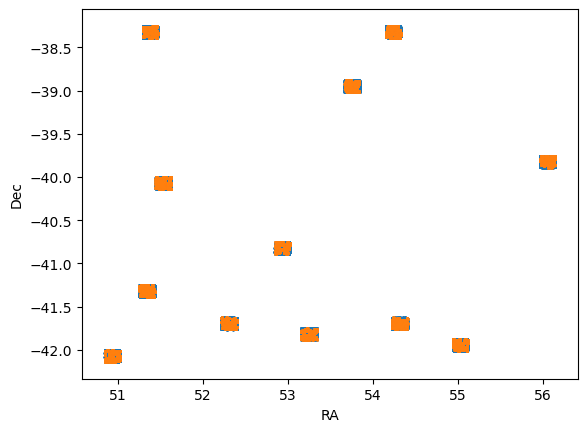

In [34]:
plt.scatter(lsst_det_coords['ra'],lsst_det_coords['dec'], s=1)
# plt.scatter(lsst_truth_coords['ra'],lsst_truth_coords['dec'], s=1)
plt.scatter(dd_det['ra'], dd_det['dec'], s=1)
plt.xlim(50.5, 51.5)
plt.ylim(-41.9,-42.2)
plt.xlabel('RA')
plt.ylabel('Dec')

## Getting Mag Cutoffs

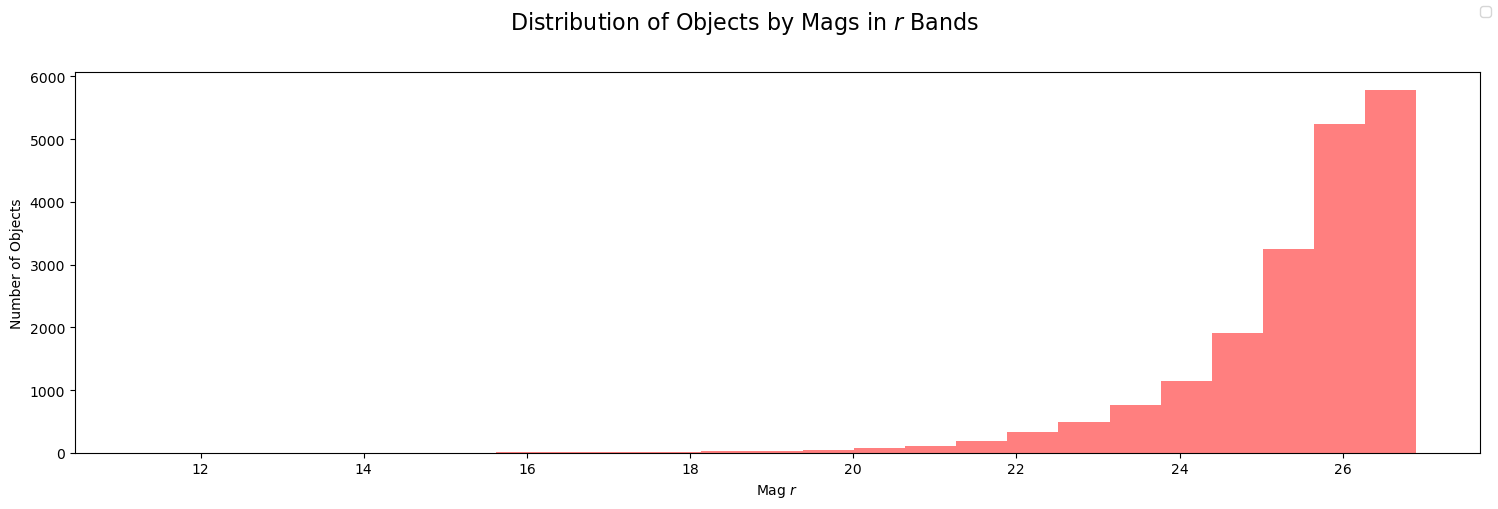

In [8]:
# mags = {'fmag': [], 'ymag': [], 'jmag': [], 'hmag': []}
mags = {'mag_r': []}
for d in data:
    for ann in d['annotations']:
        for mag in mags.keys():
            if ann[mag] != 0:
                mags[mag].append(ann[mag])

# fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey='row')
fig, axes = plt.subplots(1, 1, figsize=(15, 5), sharey='row')
# axes[0].set_ylabel('Number of Objects')
axes.set_ylabel('Number of Objects')

mags_names = mags.keys()
colors = ['red']
titles = [r'Mag $r$']
# colors = ['orange', 'blue', 'red', 'green']
# titles = ['F184 Mag', 'Y106 Mag', 'J129 Mag', 'H158 Mag']
handles, labels = [], []

# for j, (mag_name, color, title) in enumerate(zip(mags_names, colors, titles)):
#     axes[j].hist(mags[mag_name], bins=25, label=title, color=color, alpha=0.5)
#     axes[j].set_xlabel(title)

# for lsst data
for mag_name, color, title in zip(mags_names, colors, titles):
    axes.hist(mags[mag_name], bins=25, label=title, color=color, alpha=0.5)
    axes.set_xlabel(title)
    
fig.legend(handles, labels) 
fig.suptitle(r'Distribution of Objects by Mags in $r$ Bands', fontsize=16, y=1.01)
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)

Let's choose H158 Mag and set a range [20, 27]

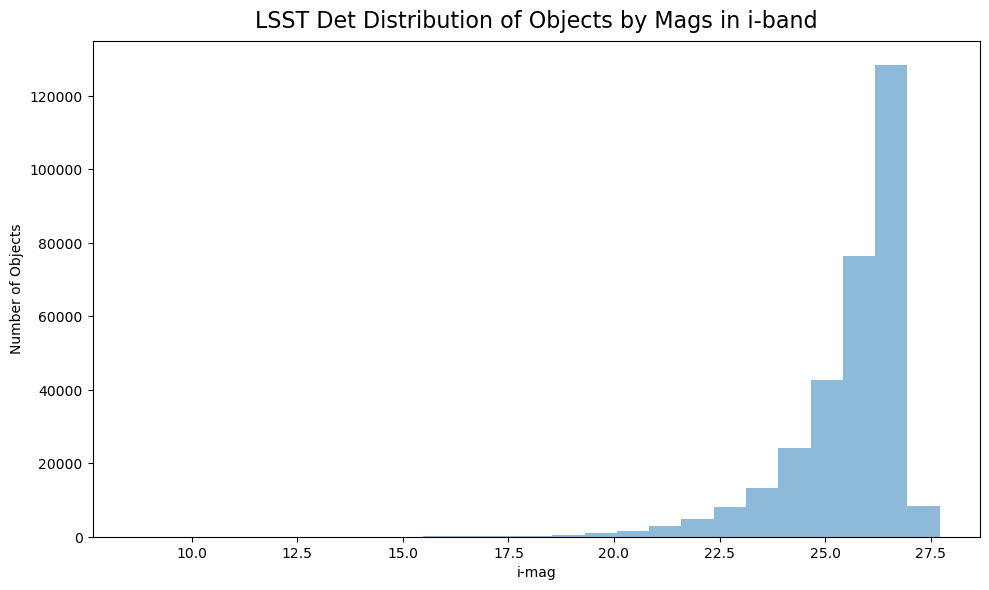

In [17]:
plt.figure(figsize=(10, 6))
plt.ylabel('Number of Objects')
plt.hist(lsst_det_dc2['mag_i'], bins=25, label='i-mag', alpha=0.5)
plt.xlabel('i-mag')
plt.title('LSST Det Distribution of Objects by Mags in i-band', fontsize=16, y=1.01)
plt.tight_layout()

Let's choose i-band and set a similar range.

LSST i-mag test cutoff: 20.03000
LSST i-mag cutoff: 23.15000


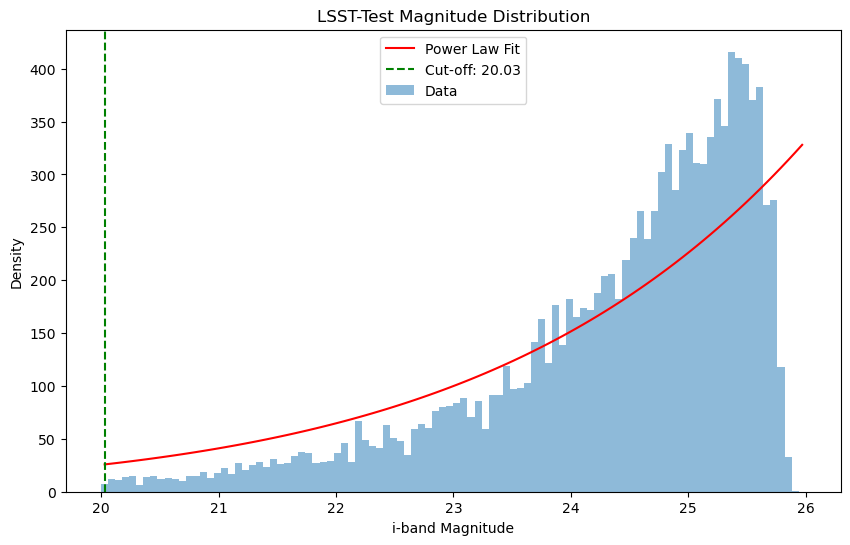

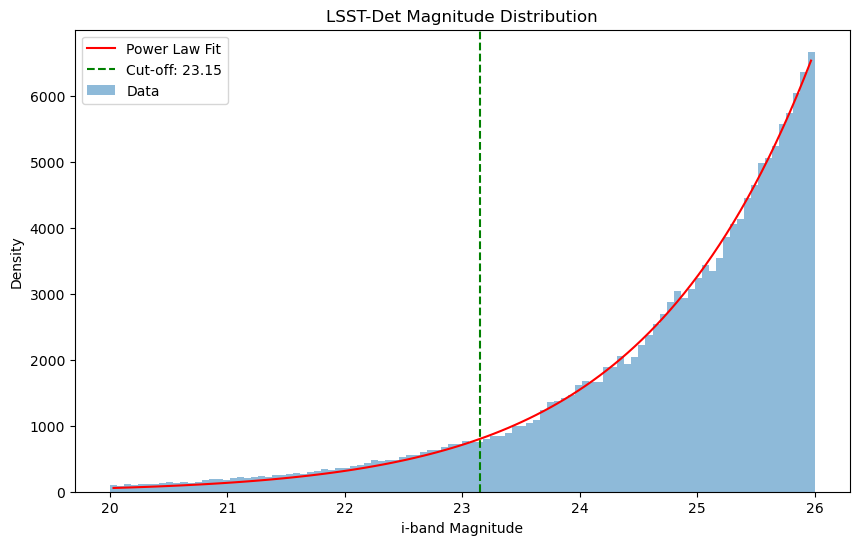

In [29]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def power_law(x, a, b):
    return a * np.power(x, b)

def find_cutoff(mags, band, survey, completeness_fraction=0.95, bins=100, plot=True):
    # histogram
    if survey == 'Roman':
        mag_range = (21, 26)
    else:
        mag_range = (20, 26)
    hist, bin_edges = np.histogram(mags, bins=bins, range=mag_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # fitting power law (can use initial guess: a=1e5, b=-0.5)
    popt, _ = curve_fit(power_law, bin_centers, hist, maxfev=10000, p0=[1e5,-0.5])
    y_fit = power_law(bin_centers, *popt)
    
    cutoff_index = np.where(hist < completeness_fraction * y_fit)[0][0]
    cutoff = bin_centers[cutoff_index]
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(bin_centers, y_fit, 'r-', label='Power Law Fit')
        plt.bar(bin_centers, hist, width=(bin_centers[1]-bin_centers[0]), alpha=0.5, label='Data')
        # Find and plot cut-off
        plt.axvline(x=cutoff, color='g', linestyle='--', label=f'Cut-off: {cutoff:.2f}')
        plt.xlabel(f'{band} Magnitude')
        plt.ylabel('Density')
#         plt.yscale('log')
        plt.title(f'{survey} Magnitude Distribution')
        plt.legend()

    return cutoff

# roman_cutoff = find_cutoff(mags['hmag'], 'H158', 'Roman')
# lsst_cutoff = find_cutoff(lsst_det['mag_i'], 'i-band', 'LSST')

lsst_test = find_cutoff(mags['mag_i'], 'i-band', 'LSST-Test')
lsst_cutoff = find_cutoff(lsst_det_dc2['mag_i'], 'i-band', 'LSST-Det')

# print(f"Roman H158-mag cutoff: {roman_cutoff:.5f}")
print(f"LSST i-mag test cutoff: {lsst_test:.5f}")
print(f"LSST i-mag cutoff: {lsst_cutoff:.5f}")

## Getting RAs and DECs of Same Regions as Test Data

In [8]:
# Roman H158-mag cutoff: 21.02500 - 26
# LSST i-mag cutoff: 22.51750 - 26

# LSST Test i-mag cutoff: 20.03000 - 26.4
# LSST i-mag cutoff: 22.51750 - 26

def get_dd_det_ras_decs(test_data, all_matched_gts, data_type, combined=False):
    ras_decs = []
    truth_info_cache = {}
    wcs_cache = {}
    for d, matched_gts in zip(test_data, all_matched_gts):
        file_name = d['file_name']
        if data_type == 'roman':
            if combined:
                truth_patch_dir = (re.search(r'truth-combined/(.+)/', file_name)).group(1)
                truth_info_filename = f'roman_data/truth-combined/{truth_patch_dir}/{truth_patch_dir}_info_all.json'
            else:
                truth_patch_dir = (re.search(r'truth/(.+)/', file_name)).group(1)
                truth_info_filename = f'roman_data/truth/{truth_patch_dir}/{truth_patch_dir}_info_all.json'            
            if truth_info_filename not in truth_info_cache:
                with open(truth_info_filename, 'r') as f:
                    truth_info_cache[truth_info_filename] = json.load(f)   
            all_truth_info = truth_info_cache[truth_info_filename] 

            if file_name not in wcs_cache:
                for truth_img in all_truth_info:
                    if truth_img['file_name'] == file_name:
                        wcs_cache[file_name] = WCS(truth_img['wcs'])
                        break
            
        else: # lsst test data
            truth_patch_dir = (re.search(r'truth/(.+)/', file_name)).group(1)
            truth_info_filename = f'lsst_data/truth/{truth_patch_dir}/{truth_patch_dir}_info.json'
            # match = re.search("./lsst_data/truth/(\d+)/(\d+,\d+)/full_c\d+\.npy", file_name)
            # tract = match.group(1)
            # patch = match.group(2)
            # truth_info_filename = f'lsst_data/truth/{tract}/{patch}/{patch}_info.json'            
            if truth_info_filename not in truth_info_cache:
                with open(truth_info_filename, 'r') as f:
                    truth_info_cache[truth_info_filename] = json.load(f)   
            all_truth_info = truth_info_cache[truth_info_filename] 

            if file_name not in wcs_cache:
                for truth_img in all_truth_info:
                    if truth_img['file_name'] == file_name:
                        wcs_cache[file_name] = WCS(truth_img['wcs'])
                        break 
        
        wcs = wcs_cache[file_name]
        for i in matched_gts:
            if len(d['annotations']) > 0 and i < len(d['annotations']):
                bbox = d['annotations'][i]['bbox']
                mag = d['annotations'][i]['mag_r']
#                 fmag = d['annotations'][i]['hmag']
                transformed_box = BoxMode.convert(bbox, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
                w = transformed_box[2] - transformed_box[0]
                h = transformed_box[3] - transformed_box[1]
                x = transformed_box[0] + w // 2
                y = transformed_box[1] + h // 2
                coords = wcs.pixel_to_world(x, y)
                ras_decs.append((coords.ra.value, coords.dec.value, mag))
    
    return ras_decs

def get_roman_truth_ras_decs(test_data, combined):#, truth_dir):
#     truth_files = np.array(glob.glob(os.path.join(truth_dir, '**/*_info_all.json'), recursive=True))
    ras = []
    decs = []
    mags = []
    truth_info_cache = {}
    processed_files = set()
    
    for d in test_data:
        file_name = d['file_name']
        if file_name in processed_files:
            continue
        processed_files.add(file_name)
        if combined:
            truth_patch_dir = (re.search(r'truth-combined/(.+)/', file_name)).group(1)
            truth_info_filename = f'roman_data/truth-combined/{truth_patch_dir}/{truth_patch_dir}_info_all.json'
        else:
            truth_patch_dir = (re.search(r'truth/(.+)/', file_name)).group(1)
            truth_info_filename = f'roman_data/truth/{truth_patch_dir}/{truth_patch_dir}_info_all.json'
            
        if truth_info_filename not in truth_info_cache:
            with open(truth_info_filename, 'r') as f:
                truth_info_cache[truth_info_filename] = json.load(f)   
        all_truth_info = truth_info_cache[truth_info_filename]
        
        for truth_img in all_truth_info:
            if truth_img['file_name'] == file_name:
                objs_data = pd.read_json(truth_img['objects_info'])
                mag_cut = (objs_data['mag_H158'].values < 26) & (objs_data['mag_H158'].values > 21.02500)
                objs_data = objs_data[mag_cut]
                ras.extend(objs_data['ra'].values)
                decs.extend(objs_data['dec'].values)
                mags.extend(objs_data['mag_H158'].values)        
#                 mags.extend(objs_data['mag_H158'].values)
                break
    
    return ras, decs, mags
        
#     for filename in truth_files:
#         if filename in 
#         with open(filename, 'r') as f:
#             all_truth_info = json.load(f)

#         for truth_img in all_truth_info:
#             objs_data = pd.read_json(truth_img['objects_info'])
#             ras.extend(objs_data['ra'].values)
#             decs.extend(objs_data['dec'].values)
#             mags.extend(objs_data['mag_H158'].values)
#             mags.extend(objs_data[objs_data['mag_H158'].values < 25.42]['mag_H158'].values)
#     plt.hist(mags, bins=40, color='orange', alpha=0.7)
#     plt.xlabel('Magnitudes')
#     plt.ylabel('Number of Images')


def get_roman_det_ras_decs(test_data, combined):#, roman_det_files):
    ras = []
    decs = []
    det_filename_cache = {}
    processed_files = set()
    
    for d in test_data:
        file_name = d['file_name']
#         roman_data/detection_fits/dc2_det_50.93_-42.0.fits.gz
        if combined:
            patch = (re.search(r'truth-combined/(.+)/', file_name)).group(1)
        else:
            patch = (re.search(r'truth/(.+)/', file_name)).group(1)
        det_filename = 'roman_data/detection_fits/' + patch[0:4] + 'det_' + patch[4:] + '.fits.gz'
        if det_filename in processed_files:
            continue
        processed_files.add(det_filename)
        if det_filename not in det_filename_cache:
            det_filename_cache[det_filename] = fits.open(det_filename)   
        det_df = Table.read(det_filename_cache[det_filename], hdu=1).to_pandas()
        det_cut_df = det_df[(det_df['flags'] < 4.0) & (det_df['mag_auto_H158'] > 21.02500) & (det_df['mag_auto_H158'] < 26)]
        ras.extend(det_cut_df['alphawin_j2000'].values)
        decs.extend(det_cut_df['deltawin_j2000'].values)
            
#     for det_file in roman_det_files:
#         det = fits.open(det_file)
#         det_df = Table.read(det,hdu=1).to_pandas()
#         det_updated_df = det_df[(det_df['flags'] < 4.0) & (det_df['mag_auto_H158'] > 21.02500) & (det_df['mag_auto_H158'] < 26)]
#         ras.extend(det_updated_df['alphawin_j2000'].values)
#         decs.extend(det_updated_df['deltawin_j2000'].values)

    return ras, decs

def get_lsst_det_ras_decs(lsst_det):
    lsst_det_cut_df = lsst_det[(lsst_det['mag_i'] > 22.51750) & (lsst_det['mag_i'] < 26.4)]
    return list(lsst_det_cut_df['ra']), list(lsst_det_cut_df['dec']), list(lsst_det_cut_df['mag_i'])

### DeepDISC Det Catalog

In [9]:
# dd_det_ras_decs = get_dd_det_ras_decs(data, all_matched_gts, combined=True)
dd_det_ras_decs = get_dd_det_ras_decs(data, all_matched_gts, data_type='lsst')

In [10]:
dd_det_ras_decs[0]

(57.099670154637614, -36.84184361999674, 22.6759986877)

In [11]:
dd_det_cat = Table(rows=[(ra, dec) for ra, dec, mag in dd_det_ras_decs if ((mag > 20.03000) and (mag < 26.4))], names=('ra', 'dec'))

### Roman Det Catalog

In [7]:
# roman_det_files = ['roman_data/detection_fits/dc2_det_50.93_-42.0.fits.gz','roman_data/detection_fits/dc2_det_51.34_-41.3.fits.gz',
#             'roman_data/detection_fits/dc2_det_51.37_-38.3.fits.gz','roman_data/detection_fits/dc2_det_51.53_-40.0.fits.gz',
#             'roman_data/detection_fits/dc2_det_52.31_-41.6.fits.gz','roman_data/detection_fits/dc2_det_52.93_-40.8.fits.gz',
#             'roman_data/detection_fits/dc2_det_53.25_-41.8.fits.gz','roman_data/detection_fits/dc2_det_53.75_-38.9.fits.gz',
#             'roman_data/detection_fits/dc2_det_54.24_-38.3.fits.gz','roman_data/detection_fits/dc2_det_54.31_-41.6.fits.gz',
#              'roman_data/detection_fits/dc2_det_55.03_-41.9.fits.gz','roman_data/detection_fits/dc2_det_56.06_-39.8.fits.gz']
roman_det_ras, roman_det_decs = get_roman_det_ras_decs(data, combined=True)#, roman_det_files)

In [8]:
roman_det_cat = Table([roman_det_ras, roman_det_decs], names=('ra', 'dec'))

### LSST Det Catalog

In [12]:
# lsst_det_ras, lsst_det_decs, lsst_mags = get_lsst_det_ras_decs(lsst_det)
lsst_det_ras, lsst_det_decs, lsst_mags = get_lsst_det_ras_decs(lsst_det_dc2)

In [13]:
lsst_det_cat = Table([lsst_det_ras, lsst_det_decs], names=('ra', 'dec'))

### Roman Truth Catalog

In [30]:
# truth_dir = './roman_data/truth-combined/'
truth_ras, truth_decs, truth_mags = get_roman_truth_ras_decs(data, True)

In [31]:
truth_cat = Table([truth_ras, truth_decs], names=('ra', 'dec'))

## Plotting RAs and DECs for Sanity Check

Text(0, 0.5, 'Dec')

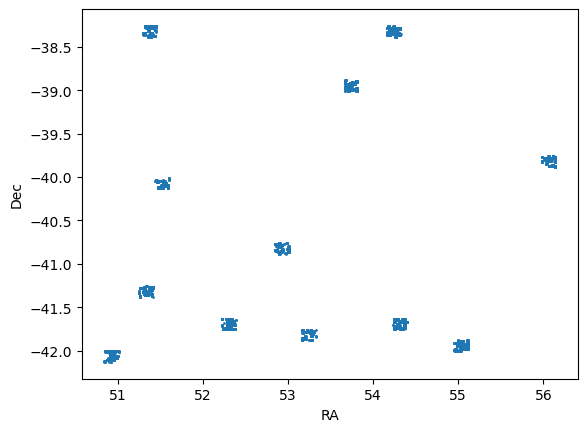

In [80]:
plt.scatter(dd_det_cat['ra'],dd_det_cat['dec'], s=1)
plt.xlabel('RA')
plt.ylabel('Dec')
# plt.xlim(51,51.75)
# plt.ylim(-38, -38.5)

Text(0, 0.5, 'Dec')

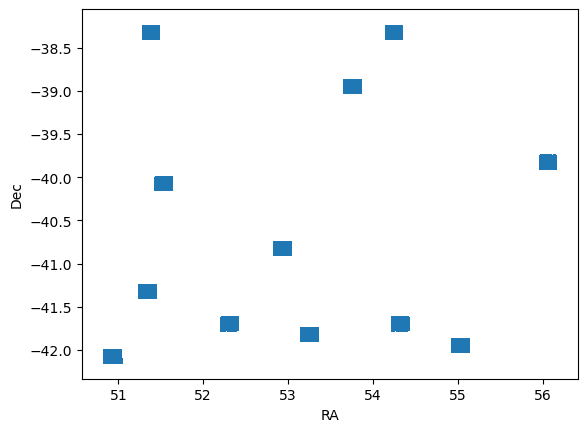

In [73]:
plt.scatter(roman_det_cat['ra'],roman_det_cat['dec'], s=1)
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0, 0.5, 'Dec')

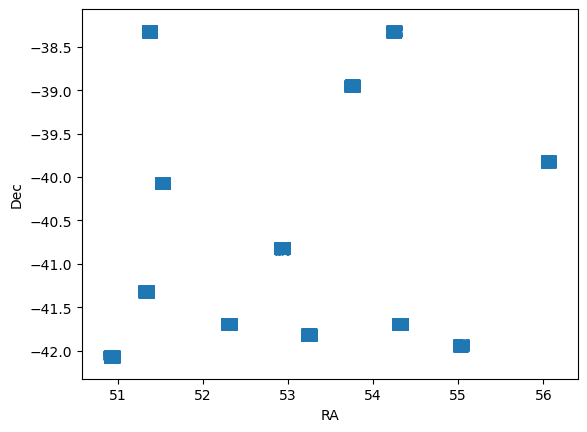

In [74]:
plt.scatter(lsst_det_cat['ra'],lsst_det_cat['dec'], s=1)
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0, 0.5, 'Dec')

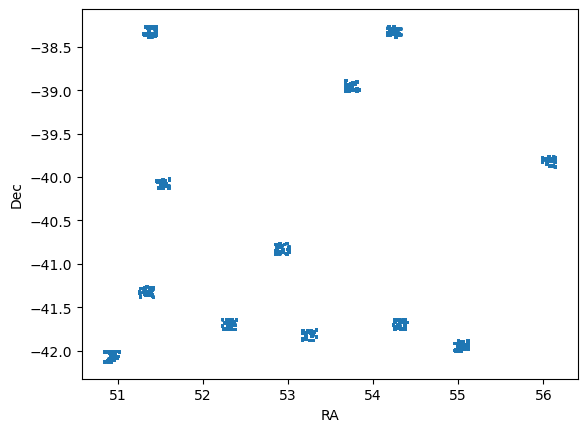

In [81]:
plt.scatter(truth_cat['ra'],truth_cat['dec'], s=1)
plt.xlabel('RA')
plt.ylabel('Dec')
# plt.xlim(51,51.75)
# plt.ylim(-38, -38.5)

## Getting Matches between Catalog using FOF

In [12]:
# points within 1 arcsecs of each other are grouped together only if there's no more than 3 friends within 1 arcsec
# None following distance means points are grouped together without any constraint on number of friends
def find_matches(cat_a, cat_b, cat_a_name, cat_b_name, linking_length=1.0):
    return FoFCatalogMatching.match({cat_a_name: cat_a, cat_b_name: cat_b},
                               {linking_length: 1})

Each **row** is a **unique astronomical object** that has been identified in the matching process. 

**group_id**: ID for the matched group. All rows with the same group_id are part of the same matched group

**row_idx**: original row index from the respective catalog (either detection or truth). Specific entry in the original catalog corresponds to this matched group

**catalog_key**: Name of the catalog indicating the source catalog of the matched entry.

In [42]:
## LSST DET VS LSST TRUTH
lsst_det_lsst_truth = find_matches(lsst_truth_coords, lsst_det_coords, 'lsst_det', 'lsst_truth', linking_length=0.5)

In [47]:
## LSST DET VS LSST TRUTH 1 arcsec
lsst_det_lsst_truth1 = find_matches(lsst_truth_coords, lsst_det_coords, 'lsst_det', 'lsst_truth')

In [13]:
## LSST DET VS DeepDISC DET
lsst_det_dd_det = find_matches(lsst_det_coords, dd_det, 'lsst_det', 'dd_det', linking_length=0.5)
lsst_det_dd_det1 = find_matches(lsst_det_coords, dd_det, 'lsst_det', 'dd_det')

In [43]:
lsst_det_lsst_truth

row_index,catalog_key,group_id
int64,str10,int64
0,lsst_det,0
0,lsst_truth,0
34,lsst_truth,0
1,lsst_det,1
1,lsst_truth,1
2,lsst_det,2
2,lsst_truth,2
3,lsst_det,3
3,lsst_truth,3


n_a: {0: 2034, 1: 83884, 2: 2021, 3: 41}
n_b: {0: 20471, 1: 49465, 2: 14612, 3: 2788, 4: 492, 5: 101, 6: 25, 7: 18, 8: 5, 9: 1, 10: 1, 18: 1}


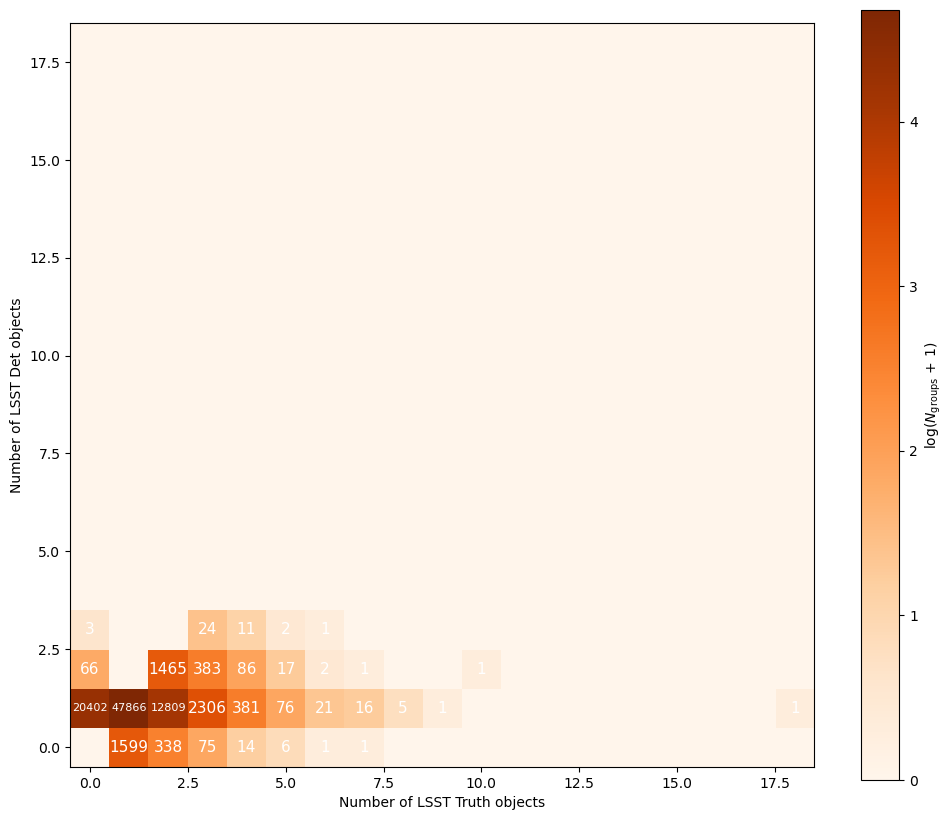

In [46]:
# plot_matches(lsst_det_lsst_truth, cat_b_name='lsst_det', xlabel='LSST Det', ylabel='LSST Truth')
plot_matches(lsst_det_lsst_truth, cat_b_name='lsst_truth', xlabel='LSST Truth', ylabel='LSST Det')

n_a: {0: 1512, 1: 77295, 2: 4821, 3: 337, 4: 24, 5: 1}
n_b: {0: 16603, 1: 49324, 2: 14581, 3: 2811, 4: 505, 5: 109, 6: 29, 7: 18, 8: 5, 9: 3, 10: 1, 18: 1}


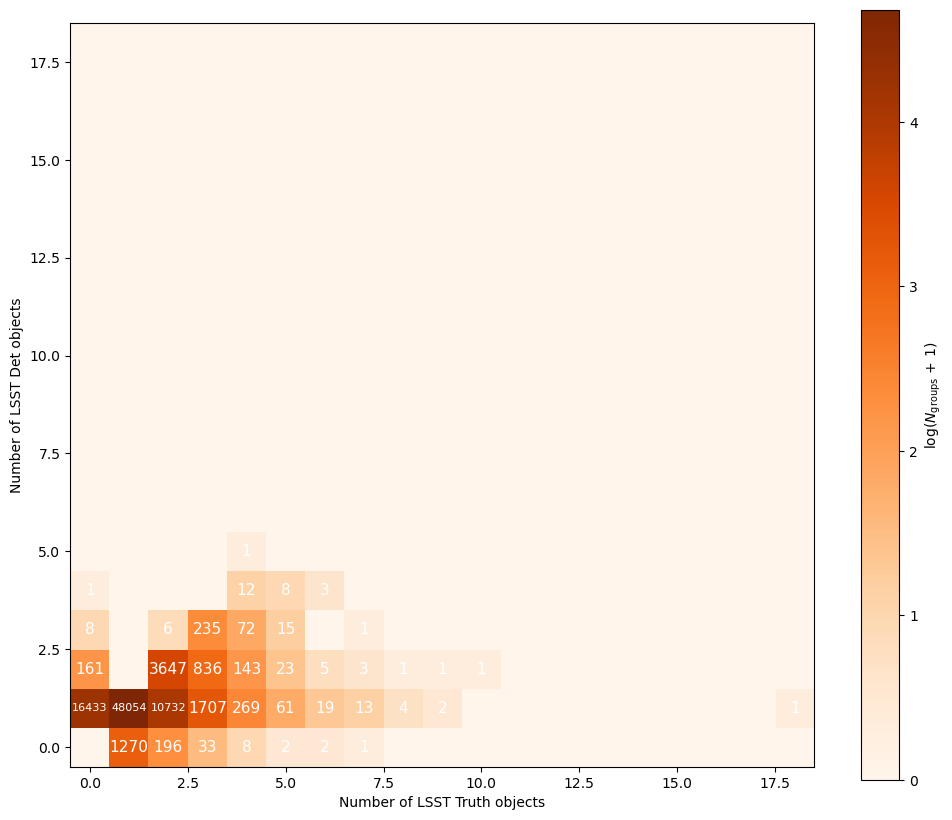

In [48]:
plot_matches(lsst_det_lsst_truth1, cat_b_name='lsst_truth', xlabel='LSST Truth', ylabel='LSST Det')

n_a: {0: 20645, 1: 49390, 2: 14616, 3: 2792, 4: 493, 5: 104, 6: 28, 7: 18, 8: 5, 9: 3, 10: 1, 18: 1}
n_b: {0: 66106, 1: 21719, 2: 269, 3: 2}


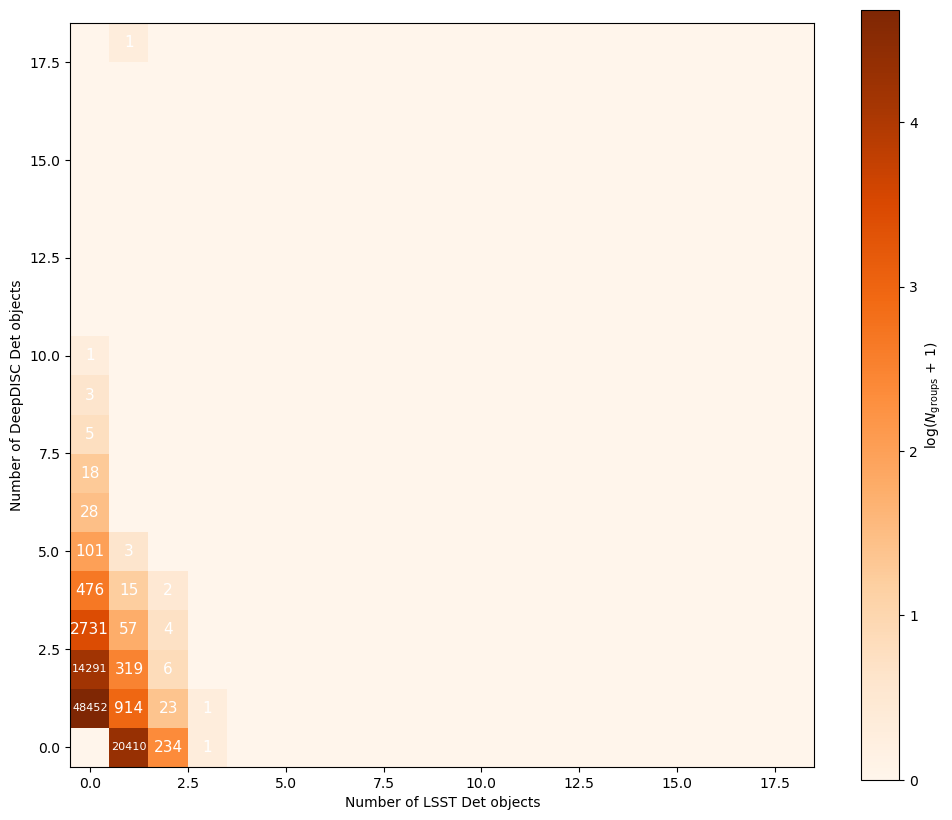

In [25]:
plot_matches(lsst_det_dd_det1, cat_b_name='dd_det', xlabel='LSST Det', ylabel='DeepDISC Det')

In [24]:
magnitudes = np.array(truth_mags)
mag_bins = np.arange(min(magnitudes) + 8.5, max(magnitudes), 0.5)

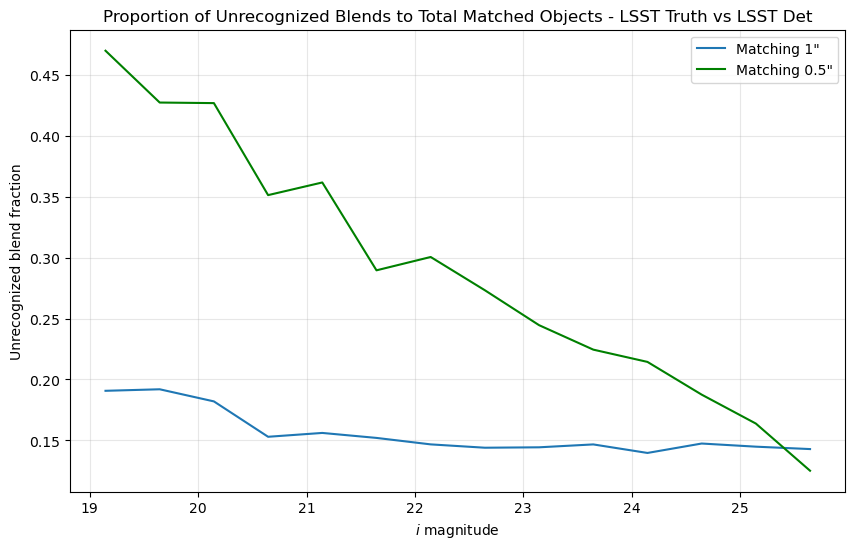

In [87]:
# overall_bf = calculate_overall_blend_fraction(roman_det_lsst_det, 'lsst_det')
# print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
# overall_bf05 = calculate_overall_blend_fraction(roman_det_lsst_det05, 'lsst_det')
# print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(lsst_det_lsst_truth1, mags=magnitudes, mag_bins=mag_bins, cat_b_name='lsst_det')
blend_fraction_05arcsec = calculate_blend_fraction(lsst_det_lsst_truth, mags=magnitudes, mag_bins=mag_bins, cat_b_name='lsst_det')
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'LSST Truth vs LSST Det')

In [ ]:
blend_fraction_1arcsec = calculate_blend_fraction(lsst_det_lsst_truth1, mags=magnitudes, mag_bins=mag_bins, cat_b_name='dd_det')
blend_fraction_05arcsec = calculate_blend_fraction(lsst_det_lsst_truth, mags=magnitudes, mag_bins=mag_bins, cat_b_name='dd_det')
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'LSST Truth vs LSST Det')

### Roman Det vs LSST Det

In [40]:
roman_det_lsst_det = find_matches(roman_det_cat, lsst_det_cat, 'roman_det', 'lsst_det')

In [41]:
roman_det_lsst_det05 = find_matches(roman_det_cat, lsst_det_cat, 'roman_det', 'lsst_det', linking_length=0.5)

In [87]:
# same as coadd pixel scale from https://academic.oup.com/mnras/article/522/2/2801/7076879?login=false
roman_det_lsst_det_ps = find_matches(roman_det_cat, lsst_det_cat, 'roman_det', 'lsst_det', linking_length=0.0575)

In [90]:
roman_det_lsst_det05

row_index,catalog_key,group_id
int64,str9,int64
0,roman_det,0
1,roman_det,1
2,roman_det,2
3,roman_det,3
4,roman_det,4
5,roman_det,5
6,roman_det,6
7,roman_det,7
8,roman_det,8


### Roman Truth vs LSST Det

In [72]:
roman_truth_lsst_det = find_matches(truth_cat, lsst_det_cat, 'truth', 'lsst_det')

In [73]:
roman_truth_lsst_det05 = find_matches(truth_cat, lsst_det_cat, 'truth', 'lsst_det', linking_length=0.5)

### Roman Det vs DeepDISC Det

In [10]:
roman_det_dd_det = find_matches(roman_det_cat, dd_det_cat, 'roman_det', 'dd_det')

In [11]:
roman_det_dd_det05 = find_matches(roman_det_cat, dd_det_cat, 'roman_det', 'dd_det', linking_length=0.5)

In [41]:
roman_det_dd_det05

row_index,catalog_key,group_id
int64,str9,int64
0,roman_det,0
1,roman_det,1
2,roman_det,2
3,roman_det,3
4,roman_det,4
5,roman_det,5
6,roman_det,6
7,roman_det,7
8,roman_det,8


### Roman Truth vs DeepDISC Det

In [32]:
roman_truth_dd_det = find_matches(truth_cat, dd_det_cat, 'truth', 'dd_det')

In [33]:
roman_truth_dd_det05 = find_matches(truth_cat, dd_det_cat, 'truth', 'dd_det', linking_length=0.5)

### LSST Det vs DeepDISC Det

In [59]:
lsst_det_dd_det = find_matches(lsst_det_cat, dd_det_cat, 'lsst_det', 'dd_det')

In [15]:
lsst_det_dd_det05 = find_matches(lsst_det_cat, dd_det_cat, 'lsst_det', 'dd_det', linking_length=0.5)

In [48]:
lsst_det_dd_det05

row_index,catalog_key,group_id
int64,str8,int64
0,lsst_det,0
1,lsst_det,1
2,lsst_det,2
3,lsst_det,3
4,lsst_det,4
5,lsst_det,5
5108,dd_det,5
6,lsst_det,6
7,lsst_det,7


### LSST Det vs Roman Truth

In [103]:
lsst_det_roman_truth = find_matches(lsst_det_cat, truth_cat, 'lsst_det', 'truth')

In [102]:
lsst_det_roman_truth05 = find_matches(lsst_det_cat, truth_cat, 'lsst_det', 'truth', linking_length=0.5)

## Plotting the Matches from FOF

In terms of completeness (are all truth objects detected?) and purity (are there spurious detections?)

In [19]:
def autofit_text(ax, text, x, y):
    fontsize = 11
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0)

    while fontsize > 1:
        t = ax.text(x, y, text, ha='center', va='center', fontsize=fontsize, 
                    color='white', bbox=bbox_props)
        
        # grab the renderer
        r = ax.figure.canvas.get_renderer()
        bb = t.get_window_extent(renderer=r).transformed(ax.transData.inverted())
        
        # check if text fits within the cell
        if bb.width < 1 and bb.height < 1:
            return
        
        t.remove()
        fontsize -= 1

    # if we got here, text is too large to fit at any readable size
    ax.text(x, y, '.', ha='center', va='center', fontsize=8, color='white')

In [20]:
# Adapted from https://nbviewer.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/matching_fof.nbconvert.ipynb
def plot_matches(results, cat_b_name, xlabel, ylabel):
    # cat_b_name is the catalog on x-axis
    # now we want to count the number of cat b and cat a objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the catalog B ("truth") and which are from catalog A ("det")
    cat_b_mask = results['catalog_key'] == cat_b_name
    cat_a_mask = ~cat_b_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    unique, counts = np.unique(n_a, return_counts=True)
    print("n_a:", dict(zip(unique, counts)))
    unique2, counts2 = np.unique(n_b, return_counts=True)
    print("n_b:", dict(zip(unique2, counts2)))
#     print(n_truth)
#     print(n_det)
    # now n_b and n_a are the number of cat b/cat a objects in each group
    # we want to make a 2d histrogram of (n_b, n_a). 
#     n_max_a = n_a.max() + 1 # to avoid the display of zero count on plot
#     n_max_b = n_b.max() + 1
    n_max = max(n_b.max(), n_a.max()) + 1
    hist_2d = np.bincount(n_a * n_max + n_b, minlength=n_max*n_max).reshape(n_max, n_max) # 
    # hist_2d = np.bincount(n_b * n_max + n_a, minlength=n_max*n_max).reshape(n_max, n_max) # 

#     plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.figure(figsize=(12,10))
    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges')
    plt.xlabel(f'Number of {xlabel} objects')
    plt.ylabel(f'Number of {ylabel} objects')
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$')
    ax = plt.gca()
    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                text = str(hist_2d[i, j])
                autofit_text(ax, text, j, i)
    

                
#     for i in range(n_max):
#         for j in range(n_max):
#             if hist_2d[i, j] > 0:
#                 plt.text(j, i, str(hist_2d[i, j]), ha='center', va='center', color='white')

In [17]:
def plot_matches(results, cat_a_name, cat_b_name, xlabel):
    # now we want to count the number of truth and object objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the truth catalog and which are from the det
    truth_mask = results['catalog_key'] == cat_b_name
    det_mask = ~truth_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_det = np.bincount(results['group_id'][det_mask], minlength=n_groups)
#     df_describe = pd.DataFrame(n_truth)
#     print(df_describe.describe())
    unique, counts = np.unique(n_det, return_counts=True)
    print("n_det:", dict(zip(unique, counts)))
    unique2, counts2 = np.unique(n_truth, return_counts=True)
    print("n_truth:", dict(zip(unique2, counts2)))
#     print(n_truth)
#     print(n_det)
    # now n_truth and n_det are the number of truth/det objects in each group
    # we want to make a 2d histrogram of (n_truth, n_det). 

    n_max = max(n_truth.max(), n_det.max()) + 1
    hist_2d = np.bincount(n_det * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

    plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower', cmap='Oranges');
    plt.xlabel(f'Number of {xlabel} objects');
    plt.ylabel('Number of DeepDISC Det objects');
    plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

    for i in range(n_max):
        for j in range(n_max):
            if hist_2d[i, j] > 0:
                plt.text(j, i, str(hist_2d[i, j]), ha='center', va='center', color='white')

### Roman Det vs LSST Det

n_a: {0: 4521, 1: 91291, 2: 1333, 3: 220, 4: 77, 5: 51, 6: 18, 7: 22, 8: 15, 9: 10, 10: 15, 11: 5, 12: 7, 13: 1, 14: 4, 15: 5, 16: 1, 22: 1}
n_b: {0: 56944, 1: 40650, 2: 3}


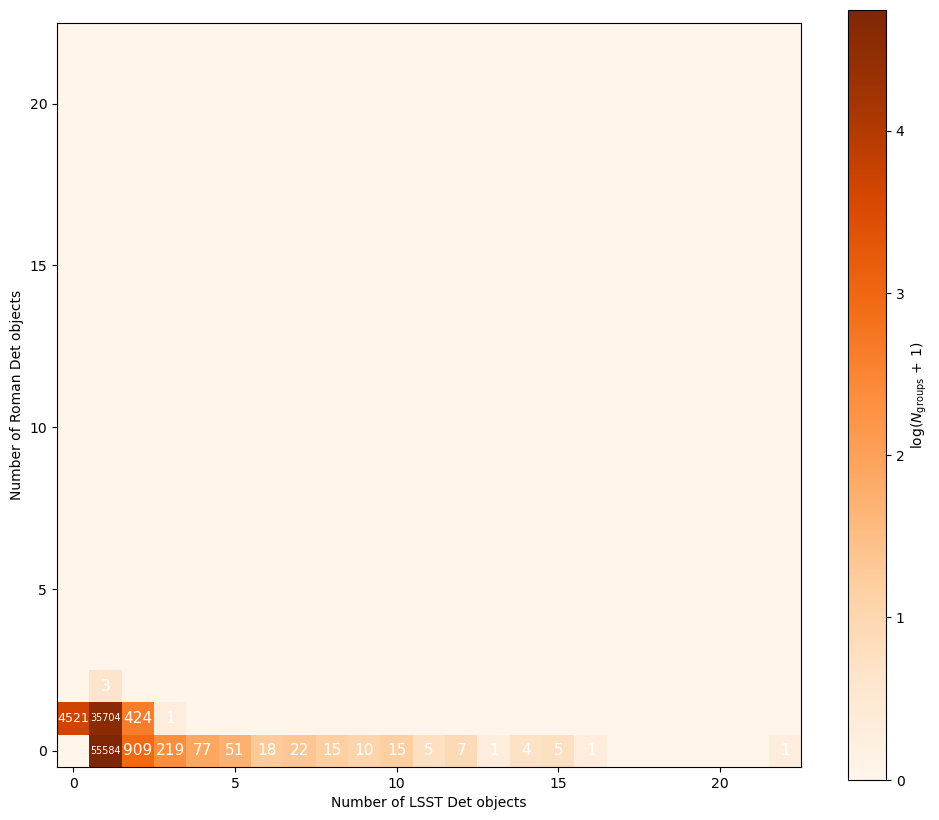

In [42]:
plot_matches(roman_det_lsst_det05, 'lsst_det', 'LSST Det', 'Roman Det')

### Roman Det vs DeepDISC Det

n_a: {0: 1048, 1: 91894, 2: 1033, 3: 219, 4: 77, 5: 51, 6: 18, 7: 22, 8: 15, 9: 10, 10: 15, 11: 5, 12: 7, 13: 1, 14: 4, 15: 5, 16: 1, 22: 1}
n_b: {0: 89253, 1: 5159, 2: 14}


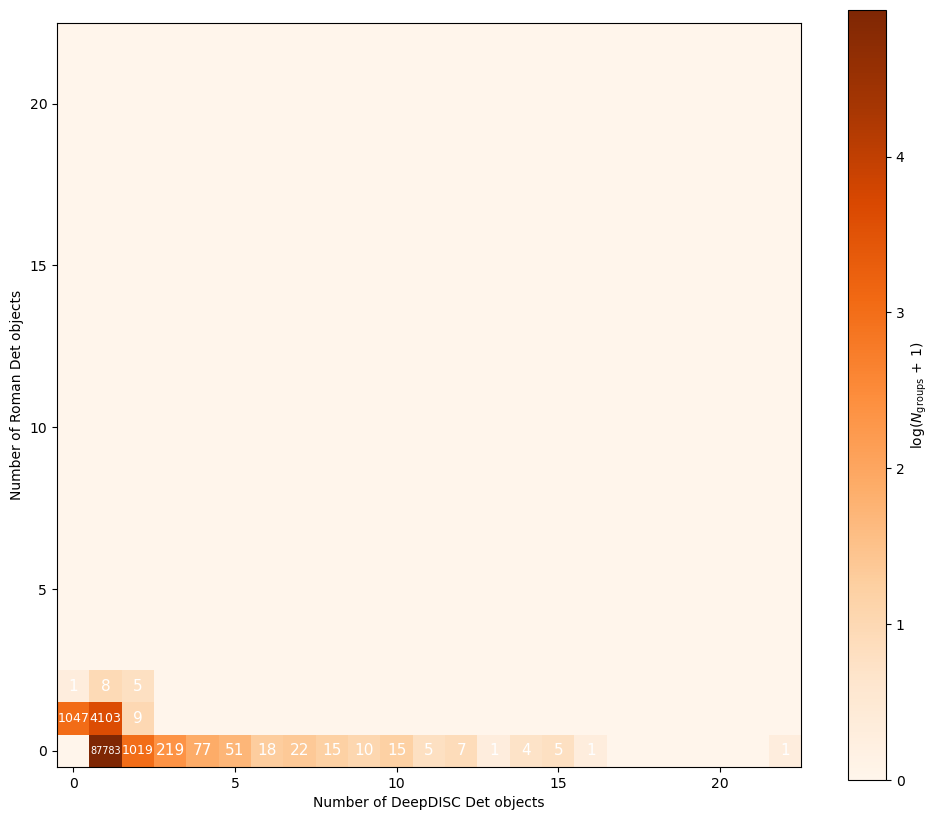

In [26]:
plot_matches(roman_det_dd_det05, 'dd_det', 'DeepDISC Det', 'Roman Det')

### Roman Truth vs DeepDISC Det

n_a: {0: 57, 1: 9351, 2: 335, 3: 88, 4: 49, 5: 29, 6: 23, 7: 14, 8: 14, 9: 10, 10: 10, 11: 6, 12: 9, 13: 7, 14: 10, 15: 1, 16: 6, 17: 5, 18: 4, 19: 2, 20: 2, 21: 3, 22: 2, 23: 1, 24: 2, 25: 1, 29: 1, 32: 2, 34: 1, 39: 1, 40: 1}
n_b: {0: 4873, 1: 5161, 2: 13}


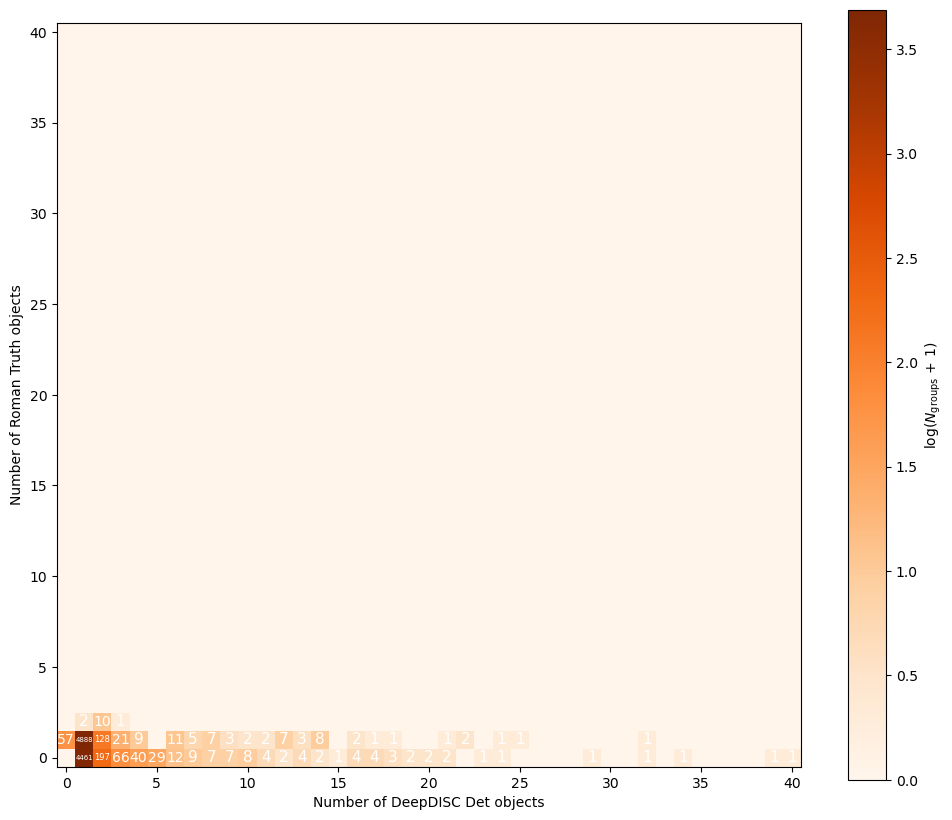

In [36]:
plot_matches(roman_truth_dd_det05, 'dd_det', 'DeepDISC Det', 'Roman Truth')

### LSST Det vs DeepDISC Det

n_a: {0: 160491, 1: 10203, 2: 8}
n_b: {0: 1294, 1: 169406, 2: 2}


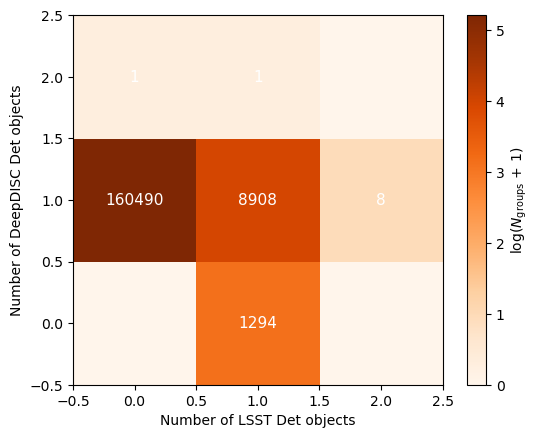

In [18]:
plot_matches(lsst_det_dd_det05, cat_b_name='lsst_det', xlabel='LSST Det', ylabel='DeepDISC Det')

0-5 Roman Detected Objects and 0-2 DeepDISC Det objects. Either no objects or very few objects are being detected by both systems

### LSST Det vs Roman Truth

n_a: {1: 4518, 2: 5085, 3: 196, 4: 71, 5: 39, 6: 12, 7: 20, 8: 12, 9: 14, 10: 11, 11: 6, 12: 4, 13: 11, 14: 5, 15: 9, 16: 4, 17: 6, 18: 4, 19: 3, 20: 2, 21: 2, 22: 1, 23: 3, 24: 1, 25: 1, 26: 1, 29: 1, 32: 1, 33: 1, 34: 1, 39: 1, 40: 1}
n_b: {0: 10047}


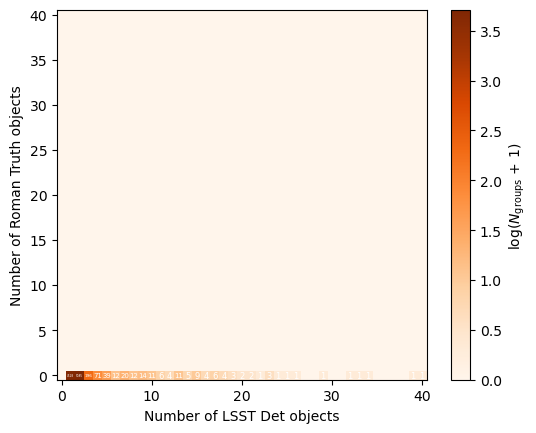

In [104]:
plot_matches(roman_truth_dd_det05, 'lsst_det', 'LSST Det', 'Roman Truth')

## Plotting the Unrecognized Blend Fraction as a function of i/h158 Magnitude

Proportion of unrecognized blends to the total matched objects against the _-band magnitude of objects.

### Calculating and Plotting Unrecognized Blend Fraction

In [41]:
def calculate_blend_fraction(results, cat_b_name, mags, mag_bins):
    cat_b_mask = results['catalog_key'] == cat_b_name
    cat_a_mask = ~cat_b_mask
    n_groups = results['group_id'].max() + 1
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    
    blend_mask = (n_b == 1) & (n_a > 1)
    # group_ids for LSST objects only
    lsst_group_ids = results['group_id'][cat_b_mask]
    # mask for blended LSST objects
    lsst_blend_mask = np.isin(lsst_group_ids, np.where(blend_mask)[0])
    # now we use this mask to select magnitudes of blended objects
    blend_mags = mags[lsst_blend_mask]
    
    blend_objects_per_bin, _ = np.histogram(blend_mags, bins=mag_bins)
    total_objects_per_bin, _ = np.histogram(mags, bins=mag_bins)
    
    blend_fraction = blend_objects_per_bin / total_objects_per_bin
    return blend_fraction


def plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, title, xlabel='i'):
    plt.figure(figsize=(10, 6))
    plt.plot(mag_bins[:-1], blend_fraction_1arcsec, '-', label='Matching 1"')
    plt.plot(mag_bins[:-1], blend_fraction_05arcsec, '-g', label='Matching 0.5"')

    plt.xlabel(f'${xlabel}$ magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)

def calculate_overall_blend_fraction(results, cat_b_name):
    cat_b_mask = results['catalog_key'] == cat_b_name
    cat_a_mask = ~cat_b_mask
    n_groups = results['group_id'].max() + 1
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)
    
    blend_mask = (n_b == 1) & (n_a > 1)
    
    total_matches = np.sum(n_b > 0)  # num of matched LSST objects
    total_blends = np.sum(blend_mask)  # num of unrecognized blends
    
    blend_fraction = total_blends / total_matches
    
    return blend_fraction
    
def old_plot_unrec_blend(results, results_05, cat_b_name, cat_title):
    mag_bins = np.arange(12, 30, 1)
    # cat_b_name is the catalog on x-axis
    # now we want to count the number of cat b and cat a objects *for each group*
    # but instead of looping over groups, we can do this

    # first we need to know which rows are from the catalog B ("truth") and which are from catalog A ("det")
    cat_b_mask = results['catalog_key'] == cat_b_name
    cat_a_mask = ~cat_b_mask

    # then np.bincount will give num of id occurrences in each group (like historgram but with int input)
    n_groups = results['group_id'].max() + 1
    n_b = np.bincount(results['group_id'][cat_b_mask], minlength=n_groups)
    # print(n_truth[n_truth>10])
    n_a = np.bincount(results['group_id'][cat_a_mask], minlength=n_groups)

    # Find groups with one cat a detection and multiple cat b (Roman Truth, Roman Det, etc) objs
    one_det_mask = n_a == 1
    multiple_truth_mask = n_b > 1
    unrec_blends_group_mask = one_det_mask & multiple_truth_mask # based on num of groups
    unrec_blends_mask = unrec_blends_group_mask[results['group_id']]
    
    # blends and total objects in each magnitude bin
    blend_mags = results['mag'][cat_a_mask & unrec_blends_mask]
    blend_counts, _ = np.histogram(blend_mags, bins=mag_bins)
    total_counts, _ = np.histogram(results['mag'][cat_a_mask], bins=mag_bins)
    
    # For 0.5 arcsec
    n_b05_mask = results_05['catalog_key'] == cat_b_name
    n_a05_mask = ~n_b05_mask
    
    n_groups_05 = results_05['group_id'].max() + 1
    n_b05 = np.bincount(results_05['group_id'][n_b05_mask], minlength=n_groups_05)
    n_a05 = np.bincount(results_05['group_id'][n_a05_mask], minlength=n_groups_05)
    
    one_det_mask_05 = n_a05 == 1
    multiple_truth_mask_05 = n_b05 > 1
    unrec_blends_group_mask_05 = one_det_mask_05 & multiple_truth_mask_05 # based on num of groups
    unrec_blends_mask_05 = unrec_blends_group_mask_05[results_05['group_id']]
    
    blend_mags_05 = results_05['mag'][n_a05_mask & unrec_blends_mask_05]
    blend_counts_05, _ = np.histogram(blend_mags_05, bins=mag_bins)
    total_counts_05, _ = np.histogram(results_05['mag'][n_a05_mask], bins=mag_bins)
    
    # proportion
    print(blend_counts, total_counts)
    blend_proportion = blend_counts / total_counts
    blend_proportion_05 = blend_counts_05 / total_counts_05
    
    # plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mag_bins[:-1] + 0.5, blend_proportion, '-o', label='Matching 1"')
    plt.plot(mag_bins[:-1] + 0.5, blend_proportion_05, '-o', label='Matching 0.5"')
    plt.xlabel('H158 magnitude')
    plt.ylabel('Unrecognized blend fraction')
    plt.title(f'Proportion of Unrecognized Blends to Total Matched Objects - {cat_title}')
    plt.legend()
    plt.grid(True, alpha=0.3)

### Roman Det vs. LSST Det

In [63]:
magnitudes = np.array(lsst_mags)
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.075)
# # mag_bins = np.arange(20, 30, 1)
# blend_fraction_1arcsec = calculate_blend_fraction(roman_det_lsst_det, 'lsst_det', magnitudes, mag_bins)
# blend_fraction_05arcsec = calculate_blend_fraction(roman_det_lsst_det05, 'lsst_det', magnitudes, mag_bins)

Unrecognized blend fraction (1 arcsec matching): 0.0479
Unrecognized blend fraction (0.5 arcsec matching): 0.0105


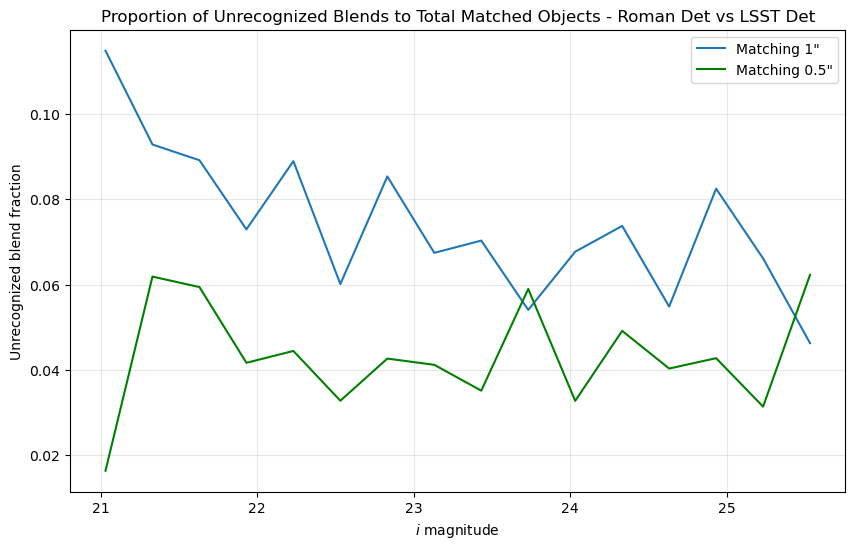

In [197]:
overall_bf = calculate_overall_blend_fraction(roman_det_lsst_det, 'lsst_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_det_lsst_det05, 'lsst_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'Roman Det vs LSST Det')

### DeepDISC Det vs LSST Det

Unrecognized blend fraction (1 arcsec matching): 0.0000
Unrecognized blend fraction (0.5 arcsec matching): 0.0000


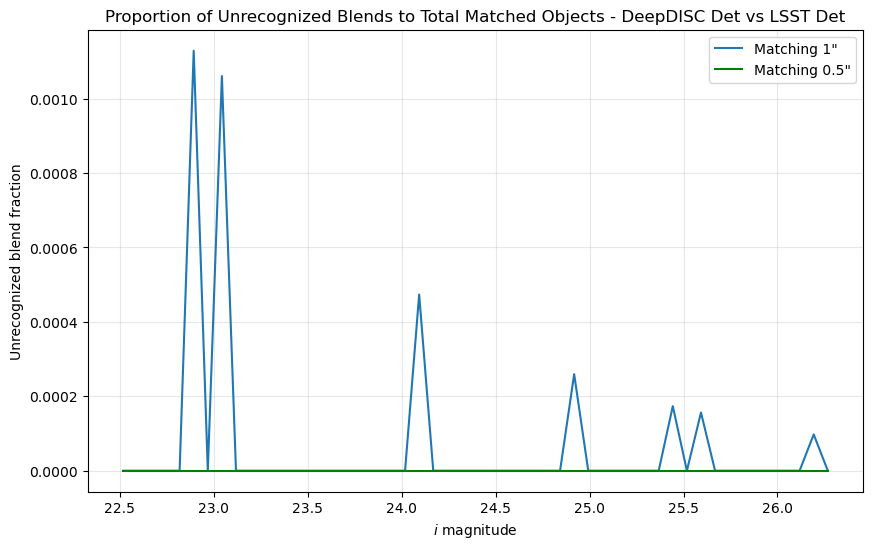

In [67]:
overall_bf = calculate_overall_blend_fraction(lsst_det_dd_det, 'lsst_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(lsst_det_dd_det05, 'lsst_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(lsst_det_dd_det, 'lsst_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(lsst_det_dd_det05, 'lsst_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs LSST Det')

In [ ]:
old_plot_unrec_blend(lsst_det_dd_det, lsst_det_dd_det05, 'lsst_det', 'DeepDISC Det vs LSST Det')

### DeepDISC Det vs Roman Truth

Unrecognized blend fraction (1 arcsec matching): 0.0695
Unrecognized blend fraction (0.5 arcsec matching): 0.0417


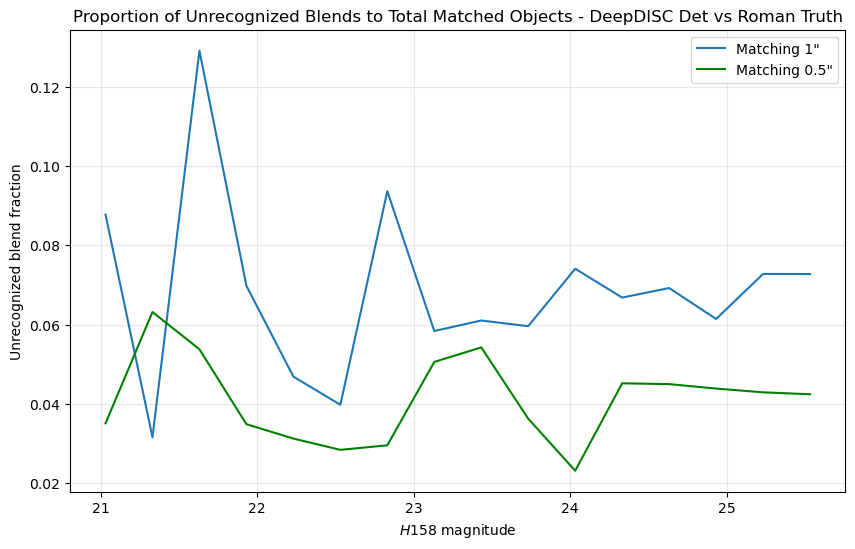

In [213]:
magnitudes = np.array([mag for _, _, mag in dd_det_ras_decs if ((mag > 21.02500) and (mag < 26))])
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.3)
overall_bf = calculate_overall_blend_fraction(roman_truth_dd_det, 'dd_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_truth_dd_det05, 'dd_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(roman_truth_dd_det, 'dd_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(roman_truth_dd_det05, 'dd_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs Roman Truth', xlabel='H158')

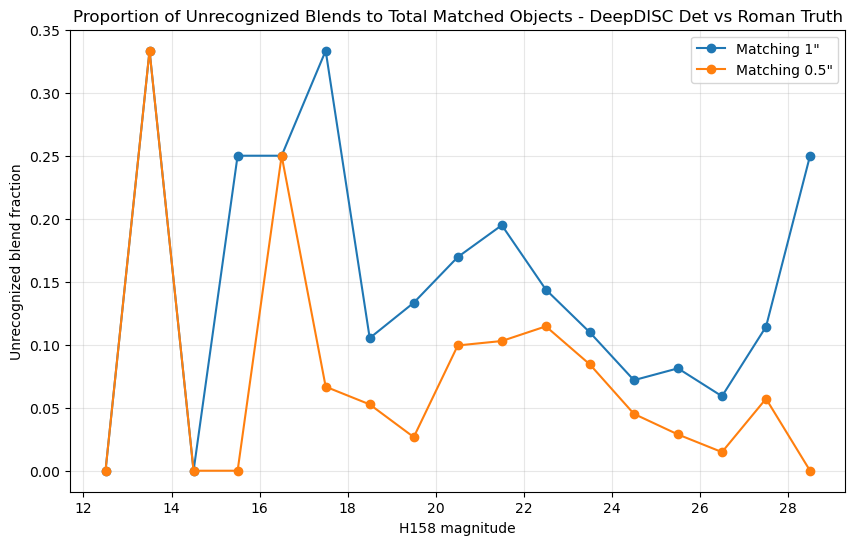

In [52]:
plot_unrec_blend(roman_truth_dd_det, roman_truth_dd_det05, 'truth', 'DeepDISC Det vs Roman Truth')

### DeepDISC Det vs Roman Det

Unrecognized blend fraction (1 arcsec matching): 0.0148
Unrecognized blend fraction (0.5 arcsec matching): 0.0017


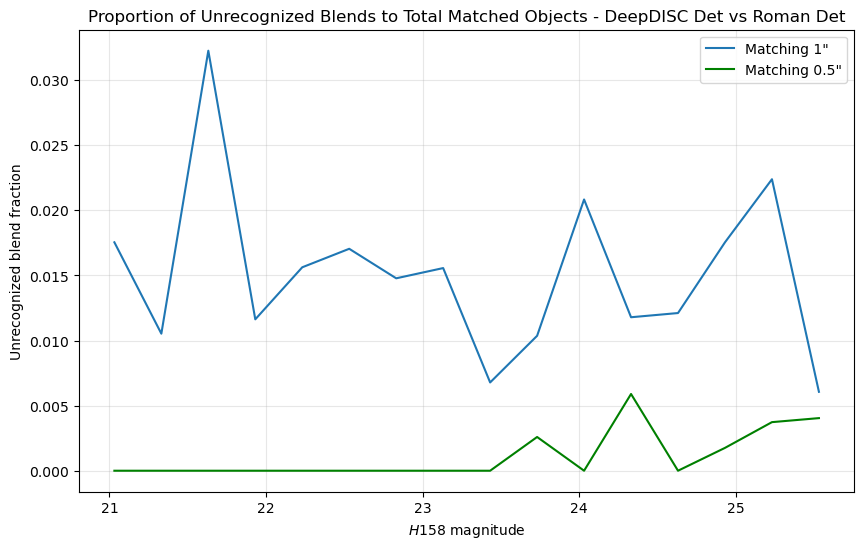

In [214]:
magnitudes = np.array([mag for _, _, mag in dd_det_ras_decs if ((mag > 21.02500) and (mag < 26))])
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.3)
overall_bf = calculate_overall_blend_fraction(roman_det_dd_det, 'dd_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_det_dd_det05, 'dd_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(roman_det_dd_det, 'dd_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(roman_det_dd_det05, 'dd_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs Roman Det', xlabel='H158')

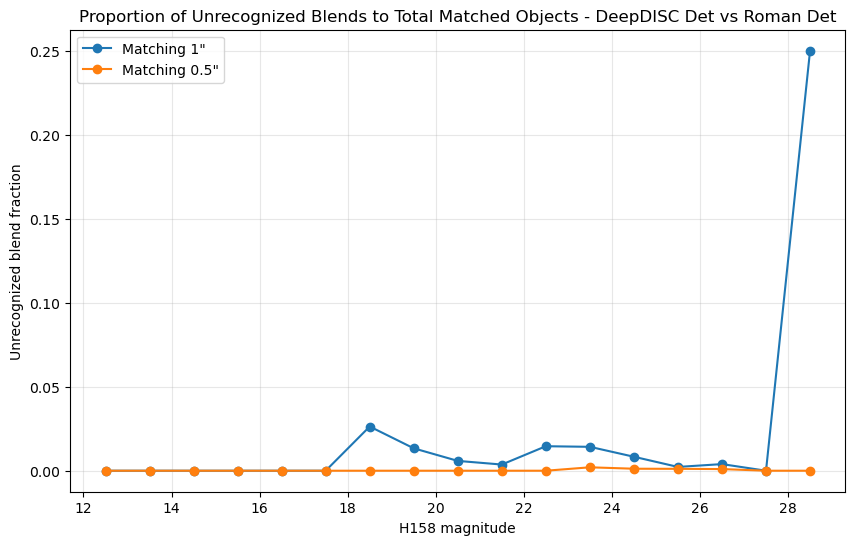

In [73]:
plot_unrec_blend(roman_det_dd_det, roman_det_dd_det05, 'roman_det', 'DeepDISC Det vs Roman Det')

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/tmp/ipykernel_1021281/3969999689.py:47: RuntimeWarning: invalid value encountered in true_divide
  blend_proportion = blend_counts / total_counts
/tmp/ipykernel_1021281/3969999689.py:48: RuntimeWarning: invalid value encountered in true_divide
  blend_proportion_05 = blend_counts_05 / total_counts_05


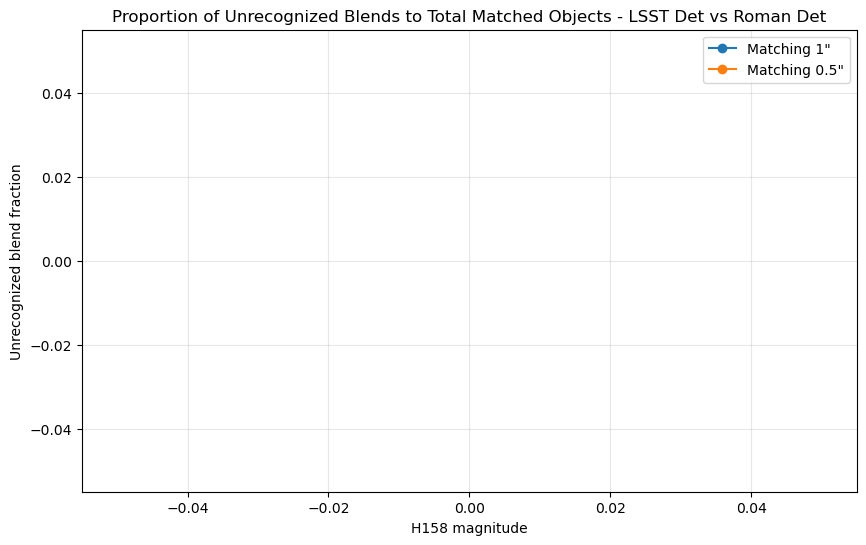

In [61]:
plot_unrec_blend(roman_det_lsst_det05, roman_det_lsst_det05, 'lsst_det', 'LSST Det vs Roman Det')

### Adding Mag Columns to results tables

In [56]:
def get_mag(row):
    if row['catalog_key'] == 'dd_det': 
        return dd_det_ras_decs[row['row_index']][2] if dd_det_ras_decs[row['row_index']][2] > 0 else np.nan
    return np.nan

In [60]:
roman_det_lsst_det['mag'] = Column([get_mag(row) for row in roman_det_lsst_det])
roman_det_lsst_det05['mag'] = Column([get_mag(row) for row in roman_det_lsst_det05])

In [51]:
roman_truth_dd_det['mag'] = Column([get_mag(row) for row in roman_truth_dd_det])
roman_truth_dd_det05['mag'] = Column([get_mag(row) for row in roman_truth_dd_det05])

In [40]:
roman_det_dd_det['mag'] = Column([get_mag(row) for row in roman_det_dd_det])
roman_det_dd_det05['mag'] = Column([get_mag(row) for row in roman_det_dd_det05])

In [57]:
lsst_det_dd_det['mag'] = Column([get_mag(row) for row in lsst_det_dd_det])
lsst_det_dd_det05['mag'] = Column([get_mag(row) for row in lsst_det_dd_det05])

# For non-combined trained model

In [179]:
with open('roman_data/annotations/test_roman.json', 'r') as f:
    data_nc = json.load(f)
run_dir = 'roman_runs/run9-swin'
with open(f'{run_dir}/all_matched_gts.pkl', 'rb') as f:
    all_matched_gts_nc = pickle.load(f)

In [186]:
dd_det_ras_decs_nc = get_dd_det_ras_decs(data_nc, all_matched_gts_nc, False)
dd_det_cat_nc = Table(rows=[(ra, dec) for ra, dec, mag in dd_det_ras_decs_nc if ((mag > 21.02500) and (mag < 26))], names=('ra', 'dec'))
roman_det_ras_nc, roman_det_decs_nc = get_roman_det_ras_decs(data_nc, False)
roman_det_cat_nc = Table([roman_det_ras_nc, roman_det_decs_nc], names=('ra', 'dec'))
truth_ras_nc, truth_decs_nc, truth_mags_nc = get_roman_truth_ras_decs(data_nc, False)
truth_cat_nc = Table([truth_ras_nc, truth_decs_nc], names=('ra', 'dec'))

In [187]:
roman_det_dd_det_nc = find_matches(roman_det_cat_nc, dd_det_cat_nc, 'roman_det', 'dd_det')
roman_det_dd_det05_nc = find_matches(roman_det_cat_nc, dd_det_cat_nc, 'roman_det', 'dd_det', linking_length=0.5)

In [188]:
roman_truth_dd_det_nc = find_matches(truth_cat_nc, dd_det_cat_nc, 'truth', 'dd_det')
roman_truth_dd_det05_nc = find_matches(truth_cat_nc, dd_det_cat_nc, 'truth', 'dd_det', linking_length=0.5)

In [190]:
lsst_det_dd_det_nc = find_matches(lsst_det_cat, dd_det_cat_nc, 'lsst_det', 'dd_det')
lsst_det_dd_det05_nc = find_matches(lsst_det_cat, dd_det_cat_nc, 'lsst_det', 'dd_det', linking_length=0.5)

### DeepDISC Det vs Roman Det

n_a: {0: 1163, 1: 91894, 2: 1033, 3: 219, 4: 77, 5: 51, 6: 18, 7: 22, 8: 15, 9: 10, 10: 15, 11: 5, 12: 7, 13: 1, 14: 4, 15: 5, 16: 1, 22: 1}
n_b: {0: 88942, 1: 5585, 2: 14}


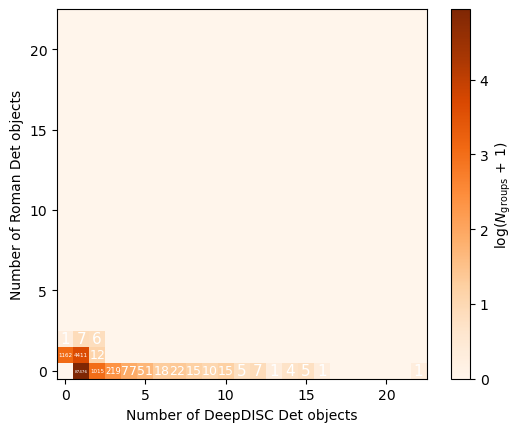

In [191]:
plot_matches(roman_det_dd_det05_nc, 'dd_det', 'DeepDISC Det', 'Roman Det')

Unrecognized blend fraction (1 arcsec matching): 0.0141
Unrecognized blend fraction (0.5 arcsec matching): 0.0021


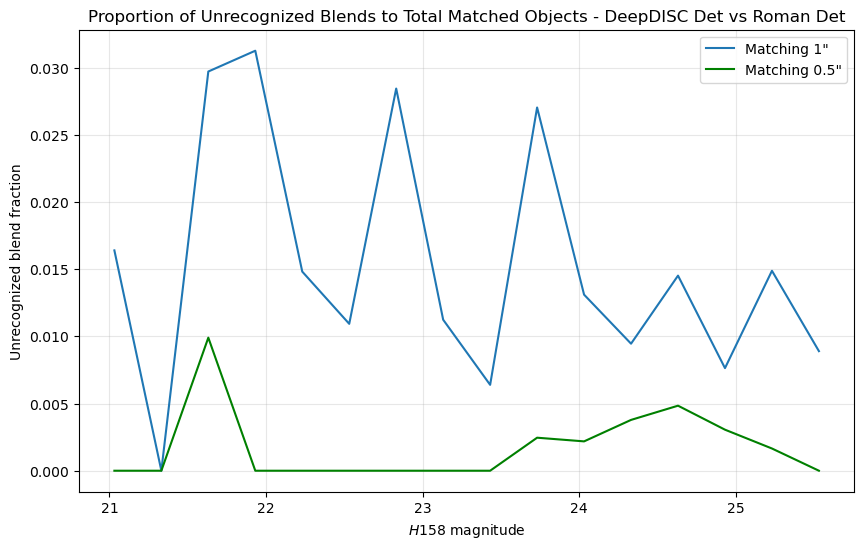

In [215]:
magnitudes = np.array([mag for _, _, mag in dd_det_ras_decs_nc if ((mag > 21.02500) and (mag < 26))])
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.3)
overall_bf = calculate_overall_blend_fraction(roman_det_dd_det_nc, 'dd_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_det_dd_det05_nc, 'dd_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(roman_det_dd_det_nc, 'dd_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(roman_det_dd_det05_nc, 'dd_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs Roman Det', xlabel='H158')

### DeepDISC Det vs Roman Truth

n_a: {0: 58, 1: 9681, 2: 353, 3: 92, 4: 50, 5: 31, 6: 23, 7: 15, 8: 15, 9: 10, 10: 12, 11: 6, 12: 9, 13: 7, 14: 10, 15: 1, 16: 6, 17: 5, 18: 4, 19: 2, 20: 2, 21: 3, 22: 2, 23: 1, 24: 2, 25: 1, 29: 1, 32: 2, 34: 1, 39: 1, 40: 1}
n_b: {0: 4807, 1: 5587, 2: 13}


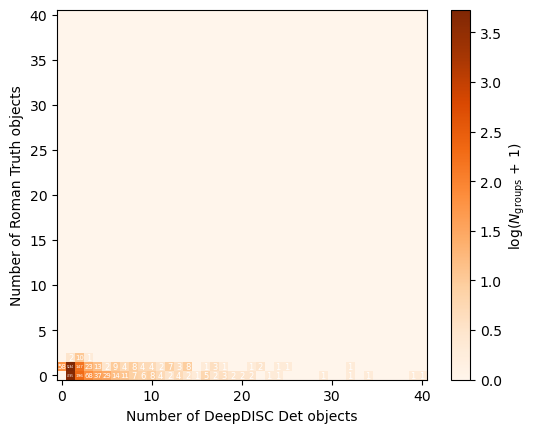

In [194]:
plot_matches(roman_truth_dd_det05_nc, 'dd_det', 'DeepDISC Det', 'Roman Truth')

Unrecognized blend fraction (1 arcsec matching): 0.0699
Unrecognized blend fraction (0.5 arcsec matching): 0.0437


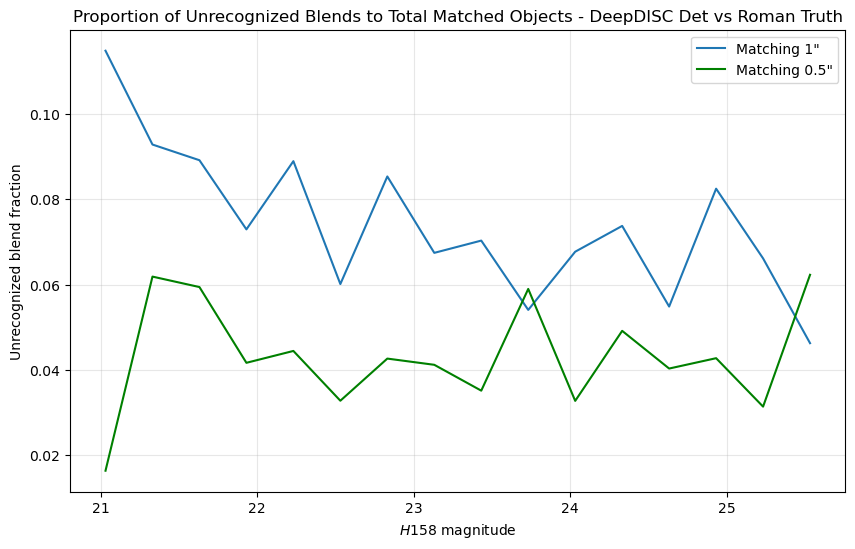

In [216]:
magnitudes = np.array([mag for _, _, mag in dd_det_ras_decs_nc if ((mag > 21.02500) and (mag < 26))])
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.3)
overall_bf = calculate_overall_blend_fraction(roman_truth_dd_det_nc, 'dd_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(roman_truth_dd_det05_nc, 'dd_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(roman_truth_dd_det_nc, 'dd_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(roman_truth_dd_det05_nc, 'dd_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs Roman Truth', xlabel='H158')

### DeepDISC Det vs LSST Det

n_a: {0: 37925, 1: 5327, 2: 134, 3: 6}
n_b: {0: 2758, 1: 40612, 2: 22}


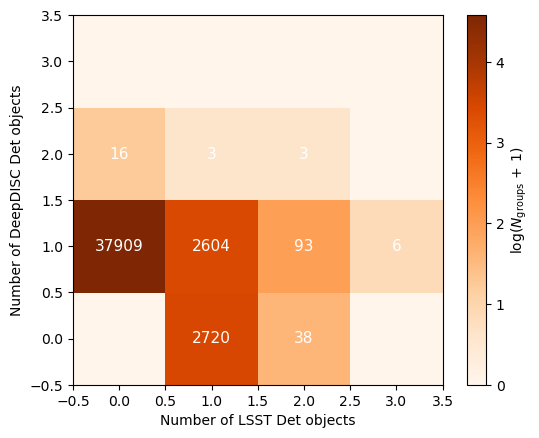

In [205]:
plot_matches(lsst_det_dd_det_nc, 'lsst_det', 'LSST Det', 'DeepDISC Det')

Unrecognized blend fraction (1 arcsec matching): 0.0024
Unrecognized blend fraction (0.5 arcsec matching): 0.0003


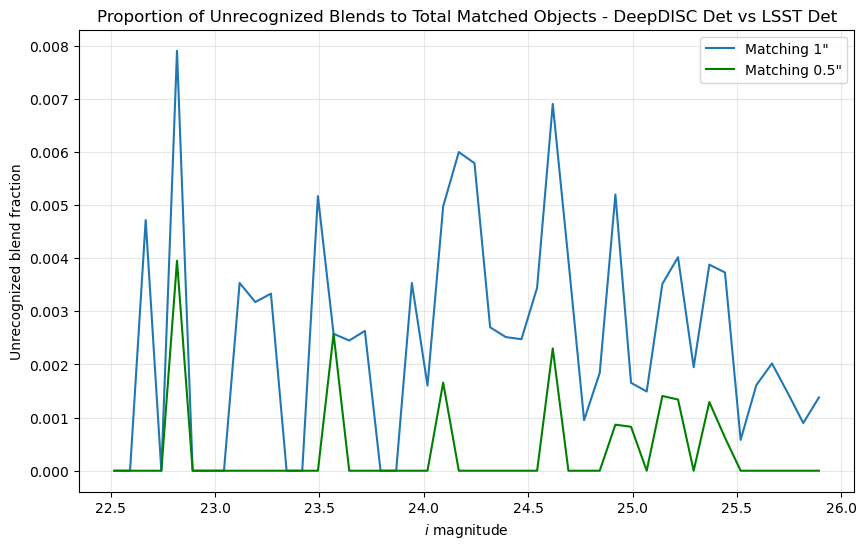

In [207]:
magnitudes = np.array(lsst_mags)
mag_bins = np.arange(min(magnitudes), max(magnitudes), 0.075)
overall_bf = calculate_overall_blend_fraction(lsst_det_dd_det_nc, 'lsst_det')
print(f"Unrecognized blend fraction (1 arcsec matching): {overall_bf:.4f}")
overall_bf05 = calculate_overall_blend_fraction(lsst_det_dd_det05_nc, 'lsst_det')
print(f"Unrecognized blend fraction (0.5 arcsec matching): {overall_bf05:.4f}")
blend_fraction_1arcsec = calculate_blend_fraction(lsst_det_dd_det_nc, 'lsst_det', magnitudes, mag_bins)
blend_fraction_05arcsec = calculate_blend_fraction(lsst_det_dd_det05_nc, 'lsst_det', magnitudes, mag_bins)
plot_unrec_blend(blend_fraction_1arcsec, blend_fraction_05arcsec, mag_bins, 'DeepDISC Det vs LSST Det')

### Miscellanous

In [20]:
# first, let's find our the IDs of the groups that have 1-to-1 truth/det match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_det == 1)))

# and then we can find the row indices in the *original* truth/det catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
det_idx = results['row_index'][one_to_one_group_mask & det_mask]

In [21]:
truth_sc = SkyCoord(truth_cat_T['ra'][truth_idx], truth_cat_T['dec'][truth_idx], unit="deg")
det_sc = SkyCoord(det_cat_T['ra'][det_idx], det_cat_T['dec'][det_idx], unit="deg")

# det_cat_T = Table(rows=det_ras_decs, names=('ra', 'dec'))
# truth_cat

delta_ra = (det_sc.ra.arcsec - truth_sc.ra.arcsec) * np.cos(np.deg2rad(0.5*(truth_sc.dec.deg + det_sc.dec.deg)))
delta_dec = det_sc.dec.arcsec - truth_sc.dec.arcsec
delta_arcsec = det_sc.separation(truth_sc).arcsec

(-0.5, 0.5, -0.5, 0.5)

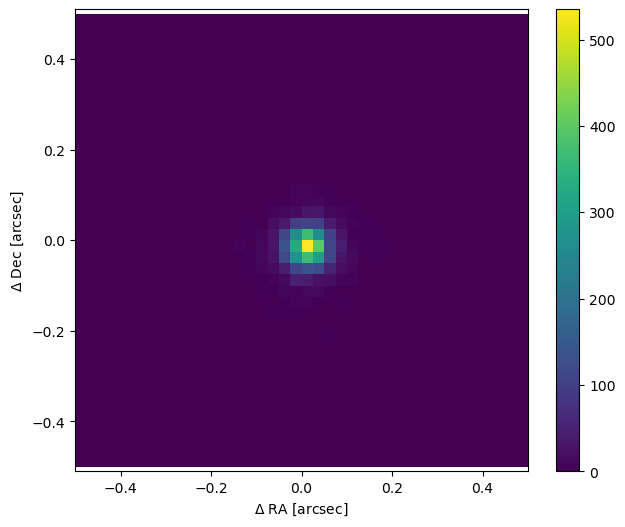

In [22]:
plt.figure(figsize=(7.3, 6))  # Pick a figuresize that will result in a square equal-axis plus colorbar
plt.hist2d(delta_ra, delta_dec, bins=40, range=((-0.5, +0.5), (-0.5, +0.5)))
plt.xlabel(r'$\Delta$ RA [arcsec]')
plt.ylabel(r'$\Delta$ Dec [arcsec]')
plt.colorbar()
plt.xlim(-0.5, +0.5)
plt.ylim(-0.5, +0.5)
plt.axis('equal')

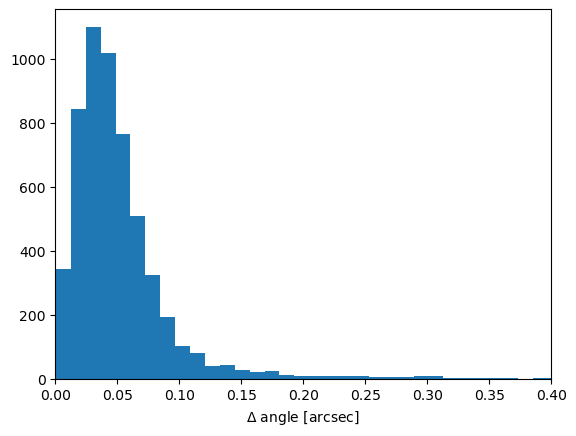

In [23]:
#Plotting Delta angle for the outputs
plt.hist(delta_arcsec, bins=80);
plt.xlim(0, 0.4);
plt.xlabel(r'$\Delta$ angle [arcsec]');